# Call Data

In [ ]:
import os
import shutil
import random
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, f1_score

In [1]:
base_dir = "/Users/romeromusadat/Library/CloudStorage/OneDrive-Personal/OneDrive/Matkul/Semester 6/new/Files"
parent_dir = os.path.dirname(base_dir.rstrip(os.sep))

## Pindahkan gambar korup ke folder terpisah 


In [2]:
corrupted_dir = os.path.join(parent_dir, "corrupted_images")
os.makedirs(corrupted_dir, exist_ok=True)

def clean_corrupted_images(folder_path, corrupted_dest):
    corrupted_files = []
    for root, _, files in os.walk(folder_path):
        for fname in files:
            file_path = os.path.join(root, fname)
            ext = fname.lower().split('.')[-1]
            if ext not in ("jpg", "jpeg", "png"):
                continue
            if os.path.getsize(file_path) == 0:
                corrupted_files.append(file_path)
            else:
                try:
                    img = Image.open(file_path); img.verify()
                except Exception:
                    corrupted_files.append(file_path)
            if file_path in corrupted_files:
                rel = os.path.relpath(file_path, folder_path)
                tgt = os.path.join(corrupted_dest, rel)
                os.makedirs(os.path.dirname(tgt), exist_ok=True)
                shutil.move(file_path, tgt)
    return corrupted_files

print("Memeriksa gambar kosong/korup…")
bad_list = clean_corrupted_images(base_dir, corrupted_dir)
if bad_list:
    print(f"  ⇒ Ditemukan {len(bad_list)} file invalid, dipindah ke:\n       {corrupted_dir}")
else:
    print("  ⇒ Tidak ada gambar rusak atau kosong.")

Memeriksa gambar kosong/korup…
  ⇒ Tidak ada gambar rusak atau kosong.


# 2) Buat folder split: train/val/test 


In [ ]:
split_dir = os.path.join(parent_dir, "splits")
train_dir = os.path.join(split_dir, "train")
val_dir   = os.path.join(split_dir, "val")
test_dir  = os.path.join(split_dir, "test")
for d in (train_dir, val_dir, test_dir):
    os.makedirs(d, exist_ok=True)

#  3) Split file per kelas ke 70/20/10 


In [3]:
for class_name in os.listdir(base_dir):
    src_class_dir = os.path.join(base_dir, class_name)
    if not os.path.isdir(src_class_dir):
        continue
    # Ambil semua file gambar valid di folder kelas
    files = [f for f in os.listdir(src_class_dir)
             if f.lower().endswith(('.jpg','jpeg','.png'))]
    random.shuffle(files)
    n = len(files)
    n_train = int(0.7 * n)
    n_val   = int(0.2 * n)
    train_files = files[:n_train]
    val_files   = files[n_train:n_train+n_val]
    test_files  = files[n_train+n_val:]

    # Copy ke folder baru
    for subset, file_list in [("train", train_files),
                              ("val",   val_files),
                              ("test",  test_files)]:
        dst_base = train_dir if subset=="train" else val_dir if subset=="val" else test_dir
        dst_class = os.path.join(dst_base, class_name)
        os.makedirs(dst_class, exist_ok=True)
        for fname in file_list:
            shutil.copy(
                os.path.join(src_class_dir, fname),
                os.path.join(dst_class, fname)
            )

print("Split data selesai: 70% train, 20% val, 10% test.")


Split data selesai: 70% train, 20% val, 10% test.


# 4) Parameter & Dataset Loading


In [4]:
img_height = 224
img_width  = 224
batch_size = 32
seed       = 123

In [5]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode="binary"
)

Found 657 files belonging to 2 classes.


In [6]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode="binary"
)

Found 187 files belonging to 2 classes.


In [7]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode="binary"
)


Found 95 files belonging to 2 classes.


In [8]:
class_names = train_ds.class_names
print("Classes:", class_names)

Classes: ['AiArtData', 'RealArt']


## Prefetch & cache untuk performa


In [9]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds   = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds  = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# 5) Data Augmentation & Transfer Learning 


In [10]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

## Load ResNet50 tanpa top


In [11]:
resnet_weights_path = "/Users/romeromusadat/Downloads/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5"
base_model = tf.keras.applications.ResNet50(
    weights=None,
    include_top=False,
    input_shape=(img_height, img_width, 3)
)
base_model.load_weights(resnet_weights_path)
base_model.trainable = False

## Bangun model full


In [12]:
inputs = layers.Input(shape=(img_height, img_width, 3))
x = data_augmentation(inputs)
x = tf.keras.applications.resnet50.preprocess_input(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model = models.Model(inputs, outputs)

In [13]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

In [14]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 224, 224)  │          0 │ sequential[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 224, 224)  │          0 │ sequential[0][0]  │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 224, 224)  │          0 │ sequential[0][0]  │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 224, 224,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 224, 224,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 7, 7,      │ 23,587,712 │ add[0][0]         │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │    262,272 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │        129 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,850,113 (90.98 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

## Callbacks


In [15]:
es  = callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
rlr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)

#  6) Training Head Layer 


In [16]:
history_tl = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=[es, rlr]
)

Epoch 1/100


2025-06-11 23:42:44.472912: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'CMYK': invalid ICC profile color space


21/21 ━━━━━━━━━━━━━━━━━━━━ 89s 4s/step - accuracy: 0.5609 - auc: 0.5820 - loss: 0.8651 - val_accuracy: 0.6257 - val_auc: 0.7128 - val_loss: 0.6403 - learning_rate: 1.0000e-04
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 72s 3s/step - accuracy: 0.6276 - auc: 0.6502 - loss: 0.6860 - val_accuracy: 0.7059 - val_auc: 0.7904 - val_loss: 0.5665 - learning_rate: 1.0000e-04
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 65s 3s/step - accuracy: 0.6733 - auc: 0.7428 - loss: 0.5953 - val_accuracy: 0.7701 - val_auc: 0.8356 - val_loss: 0.5080 - learning_rate: 1.0000e-04
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 60s 3s/step - accuracy: 0.7079 - auc: 0.8037 - loss: 0.5223 - val_accuracy: 0.7807 - val_auc: 0.8459 - val_loss: 0.4915 - learning_rate: 1.0000e-04
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 65s 3s/step - accuracy: 0.7153 - auc: 0.8145 - loss: 0.5244 - val_accuracy: 0.7807 - val_auc: 0.8589 - val_loss: 0.4782 - learning_rate: 1.0000e-04
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 60s 3s/step - accuracy: 0.7526 - auc: 

# 7) Fine-Tuning sebagian base_model 


In [17]:
base_model.trainable = True
for layer in base_model.layers[:-50]:
    layer.trainable = False

In [18]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

In [19]:
history_ft = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=[es, rlr]
)

Epoch 1/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 167s 8s/step - accuracy: 0.8648 - auc: 0.9579 - loss: 0.3038 - val_accuracy: 0.8128 - val_auc: 0.8917 - val_loss: 0.4454 - learning_rate: 1.0000e-05
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 151s 7s/step - accuracy: 0.8981 - auc: 0.9715 - loss: 0.2620 - val_accuracy: 0.8075 - val_auc: 0.8850 - val_loss: 0.4718 - learning_rate: 1.0000e-05
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 177s 9s/step - accuracy: 0.9087 - auc: 0.9681 - loss: 0.2671 - val_accuracy: 0.8182 - val_auc: 0.8878 - val_loss: 0.4433 - learning_rate: 1.0000e-05
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 148s 7s/step - accuracy: 0.9174 - auc: 0.9767 - loss: 0.2353 - val_accuracy: 0.8128 - val_auc: 0.8870 - val_loss: 0.4405 - learning_rate: 1.0000e-05
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 128s 6s/step - accuracy: 0.9467 - auc: 0.9855 - loss: 0.2026 - val_accuracy: 0.7968 - val_auc: 0.8877 - val_loss: 0.4425 - learning_rate: 1.0000e-05
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy

In [28]:
val_loss, val_acc, val_auc = model.evaluate(val_ds)
print(f"\nFinal Validation accuracy: {val_acc:.4f}, AUC: {val_auc:.4f}")

acc      = history_tl.history['accuracy'] + history_ft.history['accuracy']
val_acc  = history_tl.history['val_accuracy'] + history_ft.history['val_accuracy']
loss     = history_tl.history['loss'] + history_ft.history['loss']
val_loss = history_tl.history['val_loss'] + history_ft.history['val_loss']
epochs_range = range(len(acc))

6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.7843 - auc: 0.8696 - loss: 0.5114

Final Validation accuracy: 0.8128, AUC: 0.8870


In [31]:
y_true = []
y_prob = []
for images, labels in val_ds:
    probs = model.predict(images)
    y_true.extend(labels.numpy().flatten().tolist())
    y_prob.extend(probs.flatten().tolist())

y_true = np.array(y_true)
y_prob = np.array(y_prob)
y_pred = (y_prob >= 0.5).astype(int)

cm = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:")
print(cm)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step

Confusion Matrix:
[[90 13]
 [22 62]]


2025-06-12 00:23:57.506857: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


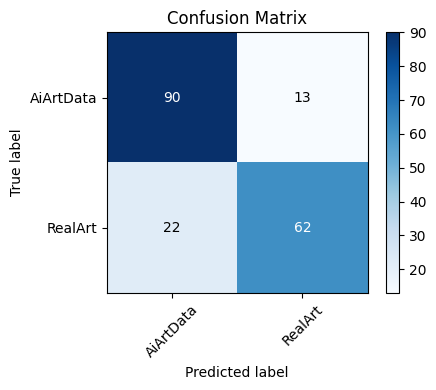

In [32]:
plt.figure(figsize=(5,4))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center",
                 va="center",
                 color="white" if cm[i, j] > thresh else "black")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

# 8) Evaluasi pada Test Set


In [20]:
test_loss, test_acc, test_auc = model.evaluate(test_ds)
print(f"\nTest accuracy: {test_acc:.4f}, AUC: {test_auc:.4f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.8692 - auc: 0.8896 - loss: 0.4264

Test accuracy: 0.8947, AUC: 0.9128


In [21]:
y_true, y_prob = [], []
for images, labels in test_ds:
    probs = model.predict(images)
    y_true.extend(labels.numpy().flatten().tolist())
    y_prob.extend(probs.flatten().tolist())

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


2025-06-12 00:21:44.301466: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [22]:
y_true = np.array(y_true)
y_prob = np.array(y_prob)
y_pred = (y_prob >= 0.5).astype(int)

## Metrics F1 dan classification report


In [23]:
f1       = f1_score(y_true, y_pred, average='binary')
f1_macro = f1_score(y_true, y_pred, average='macro')
print(f"\nF1 Score (Binary): {f1:.4f}")
print(f"F1 Score (Macro) : {f1_macro:.4f}")
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


F1 Score (Binary): 0.8810
F1 Score (Macro) : 0.8933

Classification Report:
              precision    recall  f1-score   support

   AiArtData       0.91      0.91      0.91        53
     RealArt       0.88      0.88      0.88        42

    accuracy                           0.89        95
   macro avg       0.89      0.89      0.89        95
weighted avg       0.89      0.89      0.89        95



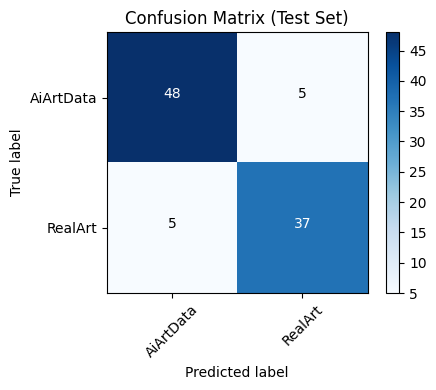

In [24]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix (Test Set)')
plt.colorbar()
ticks = np.arange(len(class_names))
plt.xticks(ticks, class_names, rotation=45)
plt.yticks(ticks, class_names)
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center",
                 color="white" if cm[i, j] > thresh else "black")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

# 9) Plot Akurasi & Loss Gabungan


In [25]:
acc      = history_tl.history['accuracy'] + history_ft.history['accuracy']
val_acc  = history_tl.history['val_accuracy'] + history_ft.history['val_accuracy']
loss     = history_tl.history['loss'] + history_ft.history['loss']
val_loss = history_tl.history['val_loss'] + history_ft.history['val_loss']
epochs_range = range(len(acc))

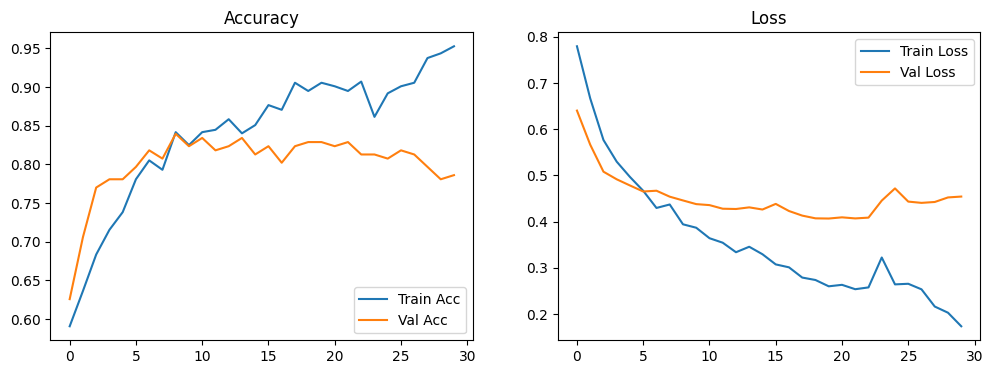

In [26]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(epochs_range, acc,     label='Train Acc')
plt.plot(epochs_range, val_acc, label='Val Acc')
plt.legend(loc='lower right')
plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_range, loss,     label='Train Loss')
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.show()

In [33]:
model.save("/Users/romeromusadat/Library/CloudStorage/OneDrive-Personal/OneDrive/Matkul/Semester 6/new/transfer_resnet50_with_report.h5")
print("\nModel disimpan sebagai transfer_resnet50_with_report.h5")



Model disimpan sebagai transfer_resnet50_with_report.h5
